In [1]:
import minterpy as mp
import numpy as np
import numpy.linalg as la
from scipy.special import eval_legendre
import matplotlib.pyplot as plt

In [10]:
def get_legendre_for_multiindex(mi):
    def l(xx):
        return np.prod([eval_legendre(mi[i], xx[i]) for i in range(mi.shape[0])])

In [9]:
def legendre_coeffs(f, spatial_dimension=6, poly_degree=5, lp_degree=np.inf):
    
    mi = mp.MultiIndexSet.from_degree(
        spatial_dimension=spatial_dimension,
        poly_degree=poly_degree,
        lp_degree=lp_degree
    )

    grd = mp.Grid(mi)
    P = grd.unisolvent_nodes

    L = [get_legendre_for_multiindex(m) for m in mi]
    A = np.array([[L[i](p) for ]])


3

In [2]:
import numpy as np


domain = np.array([
    [50, 150],
    [25, 70],
    [0.5, 3],
    [1.2, 2.5],
    [0.25, 1.2],
    [50, 300],
])


def otl(Rb1, Rb2, Rf, Rc1, Rc2, beta):

    Vb1 = 12 * Rb2 / (Rb1 + Rb2)
    
    bR9 = beta * (Rc2 + 9)
    
    w1 = 0.74
    w2 = 11.35
    
    s1 = (Vb1 + w1) * bR9 / (bR9 + Rf)
    s2 = w2 * Rf / (bR9 + Rf)
    s3 = w1 * Rf * bR9 / ((bR9 + Rf) * Rc1)
    
    return s1 + s2 + s3


def otl_normalized(xx):
    params = [translate_interval(domain[i][0], domain[i][1], xx[:,i]) for i in range(domain.shape[0])]
    return otl(*params)
    
    
def translate_interval(a, b, xx):
    avg = (a + b) / 2
    scale = b - avg
    
    return xx * scale + avg

otl_normalized(np.array([[-1, 1, 1, 1, -1, -1]]))


array([8.64554243])

In [3]:
def get_nwt_interpolant(f, spatial_dimension=6, poly_degree=8, lp_degree=1.0):
    
    mi = mp.MultiIndexSet.from_degree(
        spatial_dimension=spatial_dimension,
        poly_degree=poly_degree,
        lp_degree=lp_degree
    )

    grd = mp.Grid(mi)
    lag_coeffs = f(grd.unisolvent_nodes)

    lag_poly = mp.LagrangePolynomial(
        multi_index=mi,
        coeffs=lag_coeffs,
    )
    
    return mp.LagrangeToNewton(lag_poly)()


In [4]:
def dgsm(nwt_poly, i, variance, spatial_dimension=6):
    nwt_diff = nwt_poly.partial_diff(i)
    const_mult = np.square(2 / np.pi) / variance
    vi = (nwt_diff * nwt_diff).integrate_over() * const_mult * np.power(1/2, spatial_dimension)
    return vi


In [5]:
def compute_dgsm(nwt_poly, variance):
    spatial_dimension = domain.shape[0]
    dgsm_vals = np.zeros(spatial_dimension, dtype=np.float64)
    for i in range(spatial_dimension):
        dgsm_vals[i] = dgsm(nwt_poly, i, variance)
        
    return dgsm_vals
    

In [36]:
variance_value = 1.2

In [34]:
nwt_poly = get_nwt_interpolant(otl_normalized, spatial_dimension=domain.shape[0], poly_degree=8, lp_degree=1)

In [34]:
nwt_diff = nwt_poly.partial_diff(0)

In [35]:
nwt_square = nwt_diff * nwt_diff

In [39]:
nwt_square * 5

In [36]:
nwt_square.integrate_over()

157.2865723212685

In [37]:
D = compute_dgsm(nwt_poly, variance_value)
D

array([8.29327745e-01, 5.75450533e-01, 9.80001460e-02, 3.68300555e-02,
       6.86276728e-08, 7.11587471e-05])

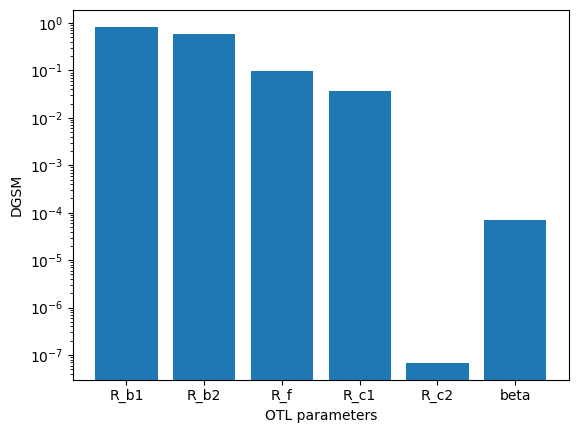

In [40]:
plt.bar(["R_b1", "R_b2", "R_f", "R_c1", "R_c2", "beta"], D)
plt.ylabel("DGSM")
plt.xlabel("OTL parameters")
plt.yscale("log")
plt.show()

In [68]:
mi = mp.MultiIndexSet.from_degree(
    spatial_dimension=6,
    poly_degree=8,
    lp_degree=1.0
)

mi.exponents.shape

(3003, 6)

In [4]:
def get_asbm_c_matrix(nwt_poly, spatial_dimension=6):
    gradient = [nwt_poly.partial_diff(i) for i in range(spatial_dimension)]
    C = np.zeros((spatial_dimension, spatial_dimension), dtype=np.float64)
    for i in range(spatial_dimension):
        for j in range(i, spatial_dimension):
            C[i,j] = (gradient[i] * gradient[j]).integrate_over() * np.power(1/2, spatial_dimension)
            print(f"{i}, {j}")
    return C

In [5]:
def get_asbm_eigendecomposition(C):
    v, w = la.eigh(C, UPLO="U")
    return v, w

In [29]:
def runge(xx):
    return 1 / (1 + 25 * np.square(la.norm(xx, axis=1)))

In [40]:
def sum_coord(xx):
    return np.sum(xx, axis=1)

In [49]:
nwt_poly_asbm = get_nwt_interpolant(otl_normalized, domain.shape[0], 4, 2.0)

In [51]:
runge_asbm = get_nwt_interpolant(runge, domain.shape[0], 4, 2.0)

In [41]:
sum_asbm = get_nwt_interpolant(sum_coord, domain.shape[0], 4, 2.0)

In [52]:
Cr = get_asbm_c_matrix(runge_asbm, domain.shape[0])

0, 0
0, 1
0, 2
0, 3
0, 4
0, 5
1, 1
1, 2
1, 3
1, 4
1, 5
2, 2
2, 3
2, 4
2, 5
3, 3
3, 4
3, 5
4, 4
4, 5
5, 5


In [53]:
Cs = get_asbm_c_matrix(sum_asbm, domain.shape[0])

0, 0
0, 1
0, 2
0, 3
0, 4
0, 5
1, 1
1, 2
1, 3
1, 4
1, 5
2, 2
2, 3
2, 4
2, 5
3, 3
3, 4
3, 5
4, 4
4, 5
5, 5


In [56]:
get_asbm_eigendecomposition(Cs)

(array([-1.52035686e-15, -5.66948791e-16, -3.54789755e-16, -1.63653977e-16,
         9.75769311e-16,  6.00000000e+00]),
 array([[ 0.00758012,  0.24854197, -0.11344291,  0.7789214 ,  0.38976265,
          0.40824829],
        [ 0.40253907,  0.06436962, -0.69774084, -0.13933255, -0.40111887,
          0.40824829],
        [-0.30243764,  0.01811427, -0.18410493, -0.5584282 ,  0.62912638,
          0.40824829],
        [-0.09064842,  0.66256064,  0.48304331, -0.1807082 , -0.34661694,
          0.40824829],
        [-0.61600077, -0.52089371,  0.03044004,  0.16026252, -0.39488664,
          0.40824829],
        [ 0.59896764, -0.47269278,  0.48180532, -0.06071497,  0.12373342,
          0.40824829]]))

In [59]:
vr, wr = get_asbm_eigendecomposition(Cr)
vr, wr

(array([0.00015445, 0.00015445, 0.00015445, 0.00015445, 0.00015445,
        0.00015446]),
 array([[ 0.18184815, -0.18606161,  0.07403968,  0.16697199, -0.85573602,
         -0.40824829],
        [-0.12843358,  0.14848054, -0.3314772 , -0.71195681, -0.42193843,
          0.40824829],
        [ 0.00731175,  0.56643884, -0.69206035,  0.17663472,  0.04774474,
         -0.40824829],
        [-0.20984413, -0.51151549, -0.54756261,  0.46989206, -0.08382911,
          0.40824829],
        [ 0.35565702, -0.57725746, -0.31998667, -0.43728979,  0.2828452 ,
         -0.40824829],
        [ 0.88309463,  0.16615471, -0.05896753,  0.14838168, -0.01937853,
          0.40824829]]))

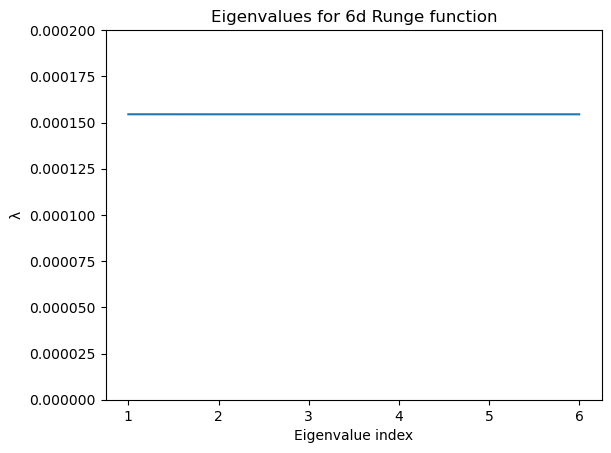

In [60]:
plt.plot(range(1, 7), np.flip(vr))
plt.ylim((0, 2e-4))
plt.xlabel("Eigenvalue index")
plt.ylabel("λ")
plt.title("Eigenvalues for 6d Runge function")
plt.savefig("eigenvals-runge.png")

In [58]:
C = get_asbm_c_matrix(nwt_poly_asbm, domain.shape[0])

0, 0
0, 1
0, 2
0, 3
0, 4
0, 5
1, 1
1, 2
1, 3
1, 4
1, 5
2, 2
2, 3
2, 4
2, 5
3, 3
3, 4
3, 5
4, 4
4, 5
5, 5


In [61]:
v, w = get_asbm_eigendecomposition(C)

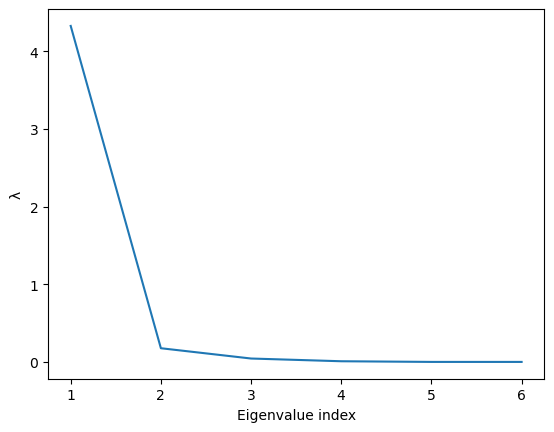

In [62]:
plt.plot(range(1, 7), np.flip(v))
plt.xlabel("Eigenvalue index")
plt.ylabel("λ")
plt.savefig("eigenvals.png")

In [63]:
def asbm(v, w, i, k):
    d = v.shape[0]
    return np.sum([
        v[j] * np.square(w[i, j])
        for j in range(d - k, d)
    ])

In [64]:
def compute_asbm(nwt_poly):
    spatial_dimension = domain.shape[0]
    C = get_asbm_c_matrix(nwt_poly, spatial_dimension)
    v, w = get_asbm_eigendecomposition(C)
    asbm_values = np.zeros(spatial_dimension, dtype=np.float64)
    for i in range(spatial_dimension):
        asbm_values[i] = asbm(v, w, i, 1)
    return asbm_values

In [65]:
asbm_values = np.zeros(domain.shape[0], dtype=np.float64)
for i in range(domain.shape[0]):
    asbm_values[i] = asbm(v, w, i, 1)
asbm_values

array([2.38054355e+00, 1.60943116e+00, 2.63008641e-01, 7.51614780e-02,
       1.33774355e-07, 6.54607258e-05])

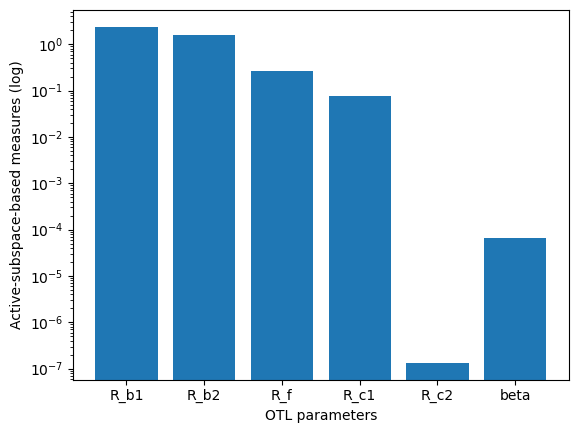

In [66]:
plt.bar(["R_b1", "R_b2", "R_f", "R_c1", "R_c2", "beta"], asbm_values)
plt.ylabel("Active-subspace-based measures (log)")
plt.xlabel("OTL parameters")
plt.yscale("log")
plt.savefig("asbm-plot-log.png")

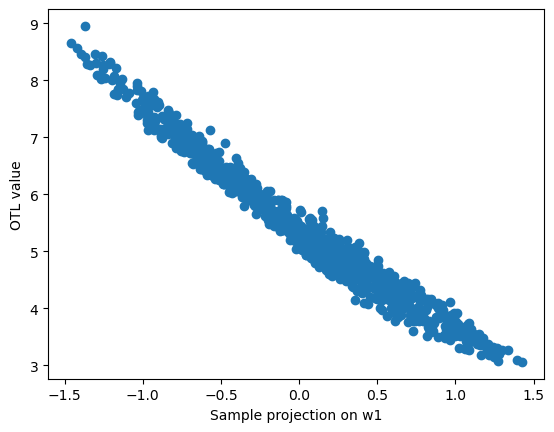

In [67]:
import numpy.random as npr

sample = npr.uniform(-1, 1, (1000, 6))
w1 = w[:,5]
proj = np.apply_along_axis(lambda x, ww=w1: np.dot(x, ww), axis=1, arr=sample)

plt.scatter(proj, otl_normalized(sample))
plt.xlabel("Sample projection on w1")
plt.ylabel("OTL value")
plt.savefig("scatter.png")